# MLP with Feature Extractor

In [2]:
import torch
import os
import optuna
import time
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset, random_split, ConcatDataset, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from skimage.feature import local_binary_pattern

import cv2

/home/jose/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-24 22:36:09.038272: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 22:36:12.336832: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Función para Feature Extractor LBP (Local Binary Patterns)

In [3]:
def extract_lbp_features(image):
    if len(image.shape) == 3 and image.shape[2] == 3:  # Color image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:  # Single-channel image
        gray = image

    lbp = local_binary_pattern(gray, 8, 1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 257), range=(0, 256))
    hist = hist.astype(np.float32)
    hist /= np.sum(hist)
    return hist

## Normalización de datos, además creación de training y testing datasets

In [4]:
"""
-- Normalize pixel values and create training and testing datasets --

This cell normalizes the pixel values and creates a training
and testing datasets considering the stratify technique.
"""

parent_folder_path = 'images/cropped_dataset/'
categories = {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}
arrays = []
category_amount = []

# get the category with the least images
for category in categories.keys():
    folder_path = os.path.join(parent_folder_path, category)
    image_files = os.listdir(folder_path)
    category_amount.append(len(image_files))

max_training = min(category_amount)

# convert the images into a pytorch dataset
for cat_folder, value in categories.items():

    folder_path = os.path.join(parent_folder_path, cat_folder)
    image_files = os.listdir(folder_path)

    for i, file_name in enumerate(image_files):

        if i >= max_training:
            break

        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path)
        image_array = np.array(image)

        # verify all images are of the desired size
        if image.size != (250, 250):
            print(file_path, " IS NOT 250x250, it is: ", image.size)
            continue

        if image_array.shape != (250, 250):
            image_array = np.dot(image_array[..., :3], [0.2989, 0.5870, 0.1140])

        # extract LBP features from image
        image_features = extract_lbp_features(image_array)

        arrays.append(image_features)

# reshape the array
arrays = np.array(arrays).astype(np.float32)
arrays = arrays / np.max(arrays)

arrays_labels = [0] * max_training
arrays_labels += [1] * max_training
arrays_labels += [2] * max_training
arrays_labels += [3] * max_training

arrays_labels = np.array(arrays_labels)

X_train, X_test, y_train, y_test = train_test_split(arrays, arrays_labels, test_size=0.2, random_state=42, stratify=arrays_labels)

y_train = to_categorical(y_train.astype(int), num_classes=4)
y_test = to_categorical(y_test.astype(int), num_classes=4)

/home/jose/.local/lib/python3.8/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


## Arquitectura 1 para modelo MLP

In [13]:
# Modelo de red MLP personalizado
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_shape=(256,)))

model_mlp.add(Dense(32, activation='sigmoid'))

model_mlp.add(Dense(16, activation='relu'))

model_mlp.add(Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model_mlp.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_mlp.fit(X_train, y_train, batch_size=128, epochs=500, verbose=1)

Epoch 1/500
72/72 [==============================] - 1s 3ms/step - loss: 1.4017 - accuracy: 0.2447
Epoch 2/500
72/72 [==============================] - 0s 3ms/step - loss: 1.3779 - accuracy: 0.2878
Epoch 3/500
72/72 [==============================] - 0s 3ms/step - loss: 1.3548 - accuracy: 0.3504
Epoch 4/500
72/72 [==============================] - 0s 3ms/step - loss: 1.3162 - accuracy: 0.3824
Epoch 5/500
72/72 [==============================] - 0s 4ms/step - loss: 1.2771 - accuracy: 0.3954
Epoch 6/500
72/72 [==============================] - 0s 4ms/step - loss: 1.2578 - accuracy: 0.4154
Epoch 7/500
72/72 [==============================] - 0s 3ms/step - loss: 1.2450 - accuracy: 0.4293
Epoch 8/500
72/72 [==============================] - 0s 3ms/step - loss: 1.2378 - accuracy: 0.4354
Epoch 9/500
72/72 [==============================] - 0s 3ms/step - loss: 1.2183 - accuracy: 0.4491
Epoch 10/500
72/72 [==============================] - 0s 3ms/step - loss: 1.2036 - accuracy: 0.4543
Epoch 11/

### Métricas de la Arquitectura 1

72/72 [==============================] - 0s 2ms/step
[[407  81  35  49]
 [ 28 439  76  28]
 [ 13 179 340  40]
 [ 36  32  30 473]]
Accuracy:  0.7257217847769029
Precision:  [0.84090909 0.6005472  0.70686071 0.80169492]
Recall:  [0.71153846 0.76882662 0.59440559 0.82837128]
F1 score:  [0.77083333 0.67434716 0.64577398 0.81481481]
General AUC: 0.8171478565179353


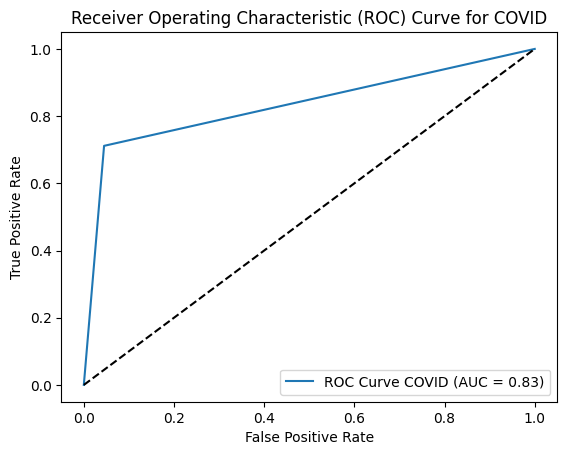

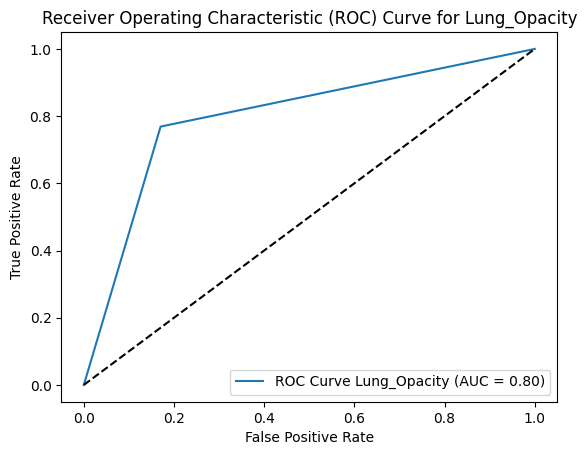

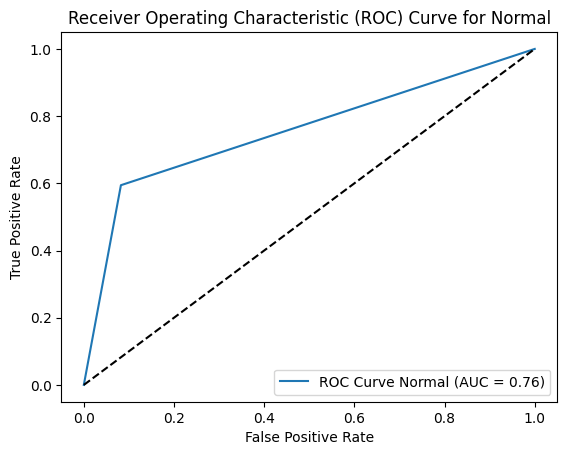

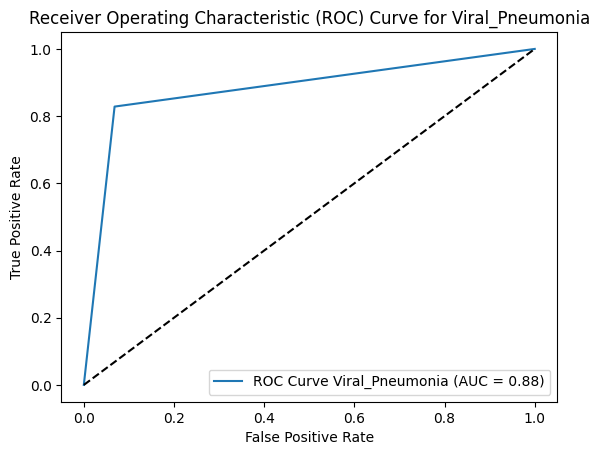

In [14]:
predictions = model_mlp.predict(X_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

# get the metrics
print(confusion_matrix(real_values, predictions))
print("Accuracy: ", accuracy_score(real_values, predictions))
print("Precision: ", precision_score(real_values, predictions, average=None))
print("Recall: ", recall_score(real_values, predictions, average=None))
print("F1 score: ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

covid_true = []
lung_op_true = []
normal_true = []
viral_pneu_true = []

covid_pred = []
lung_op_pred = []
normal_pred = []
viral_pneu_pred = []

for i in range(len(real_values)):
    
    # y_test
    covid_true.append(real_values[i] == 0)
    lung_op_true.append(real_values[i] == 1)
    normal_true.append(real_values[i] == 2)
    viral_pneu_true.append(real_values[i] == 3)

    # predictions
    covid_pred.append(predictions[i] == 0)
    lung_op_pred.append(predictions[i] == 1)
    normal_pred.append(predictions[i] == 2)
    viral_pneu_pred.append(predictions[i] == 3)

test_label_mat.append(covid_true)
test_label_mat.append(lung_op_true)
test_label_mat.append(normal_true)
test_label_mat.append(viral_pneu_true)

predictions_mat.append(covid_pred)
predictions_mat.append(lung_op_pred)
predictions_mat.append(normal_pred)
predictions_mat.append(viral_pneu_pred)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)

categories = {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}

for category, value in categories.items():

    fpr, tpr, thresholds = roc_curve(test_label_mat[value], predictions_mat[value])

    auc = roc_auc_score(test_label_mat[value], predictions_mat[value])

    plt.plot(fpr, tpr, label=f'ROC Curve {category} (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing the random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {category}')
    plt.legend(loc='lower right')
    plt.show()

## Arquitectura 2 para modelo MLP

In [15]:
# Modelo de red MLP personalizado
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_shape=(256,)))

model_mlp.add(Dense(32, activation='sigmoid'))

model_mlp.add(Dense(128, activation='relu'))

model_mlp.add(Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model_mlp.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_mlp.fit(X_train, y_train, batch_size=128, epochs=500, verbose=1)

Epoch 1/500
72/72 [==============================] - 1s 3ms/step - loss: 1.3890 - accuracy: 0.2584
Epoch 2/500
72/72 [==============================] - 0s 3ms/step - loss: 1.3820 - accuracy: 0.2696
Epoch 3/500
72/72 [==============================] - 0s 3ms/step - loss: 1.3642 - accuracy: 0.3419
Epoch 4/500
72/72 [==============================] - 0s 3ms/step - loss: 1.3021 - accuracy: 0.4093
Epoch 5/500
72/72 [==============================] - 0s 3ms/step - loss: 1.2340 - accuracy: 0.4405
Epoch 6/500
72/72 [==============================] - 0s 3ms/step - loss: 1.2078 - accuracy: 0.4574
Epoch 7/500
72/72 [==============================] - 0s 3ms/step - loss: 1.1867 - accuracy: 0.4603
Epoch 8/500
72/72 [==============================] - 0s 3ms/step - loss: 1.1733 - accuracy: 0.4680
Epoch 9/500
72/72 [==============================] - 0s 3ms/step - loss: 1.1631 - accuracy: 0.4686
Epoch 10/500
72/72 [==============================] - 0s 3ms/step - loss: 1.1537 - accuracy: 0.4702
Epoch 11/

### Métricas de la Arquitectura 2

72/72 [==============================] - 0s 2ms/step
[[425  62  46  39]
 [ 42 403  96  30]
 [ 19 139 380  34]
 [ 58  43  51 419]]
Accuracy:  0.7117235345581803
Precision:  [0.78125    0.62287481 0.66317627 0.80268199]
Recall:  [0.74300699 0.70577933 0.66433566 0.73380035]
F1 score:  [0.76164875 0.66174056 0.66375546 0.76669716]
General AUC: 0.8078156897054534


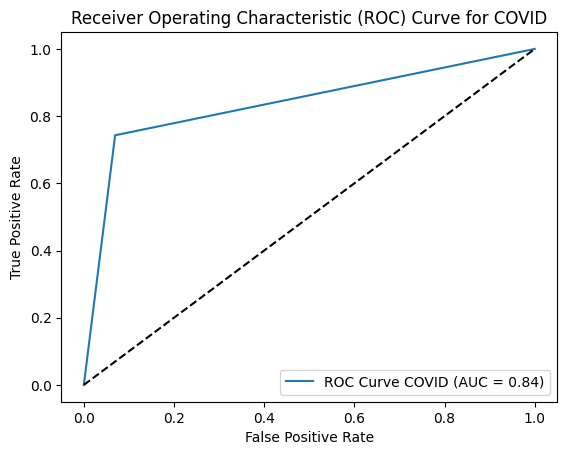

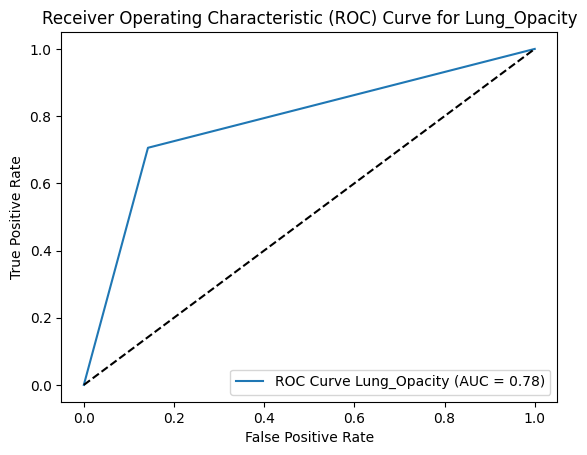

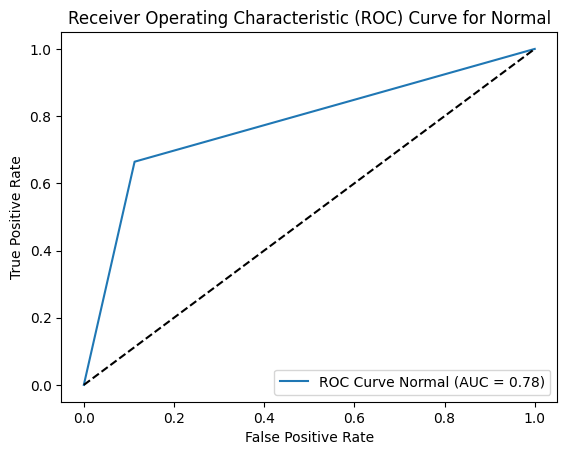

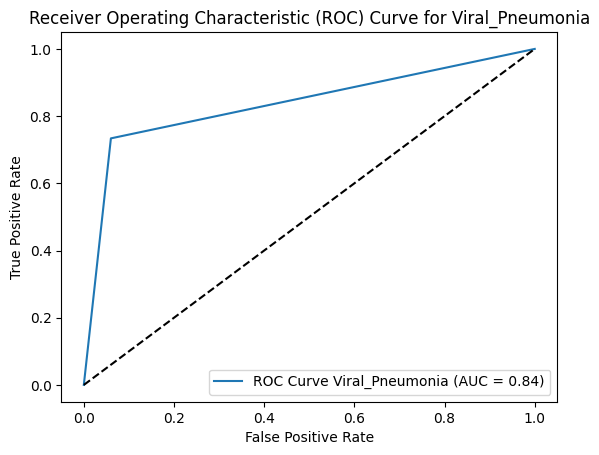

In [16]:
predictions = model_mlp.predict(X_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

# get the metrics
print(confusion_matrix(real_values, predictions))
print("Accuracy: ", accuracy_score(real_values, predictions))
print("Precision: ", precision_score(real_values, predictions, average=None))
print("Recall: ", recall_score(real_values, predictions, average=None))
print("F1 score: ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

covid_true = []
lung_op_true = []
normal_true = []
viral_pneu_true = []

covid_pred = []
lung_op_pred = []
normal_pred = []
viral_pneu_pred = []

for i in range(len(real_values)):
    
    # y_test
    covid_true.append(real_values[i] == 0)
    lung_op_true.append(real_values[i] == 1)
    normal_true.append(real_values[i] == 2)
    viral_pneu_true.append(real_values[i] == 3)

    # predictions
    covid_pred.append(predictions[i] == 0)
    lung_op_pred.append(predictions[i] == 1)
    normal_pred.append(predictions[i] == 2)
    viral_pneu_pred.append(predictions[i] == 3)

test_label_mat.append(covid_true)
test_label_mat.append(lung_op_true)
test_label_mat.append(normal_true)
test_label_mat.append(viral_pneu_true)

predictions_mat.append(covid_pred)
predictions_mat.append(lung_op_pred)
predictions_mat.append(normal_pred)
predictions_mat.append(viral_pneu_pred)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)

categories = {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}

for category, value in categories.items():

    fpr, tpr, thresholds = roc_curve(test_label_mat[value], predictions_mat[value])

    auc = roc_auc_score(test_label_mat[value], predictions_mat[value])

    plt.plot(fpr, tpr, label=f'ROC Curve {category} (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing the random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {category}')
    plt.legend(loc='lower right')
    plt.show()

## Arquitectura 3 para modelo MLP

In [17]:
# Modelo de red MLP personalizado
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_shape=(256,)))

model_mlp.add(Dense(16, activation='relu'))

model_mlp.add(Dense(256, activation='relu'))

model_mlp.add(Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model_mlp.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model_mlp.fit(X_train, y_train, batch_size=128, epochs=500, verbose=1)

Epoch 1/500
72/72 [==============================] - 1s 3ms/step - loss: 1.3644 - accuracy: 0.3622
Epoch 2/500
72/72 [==============================] - 0s 3ms/step - loss: 1.2418 - accuracy: 0.4488
Epoch 3/500
72/72 [==============================] - 0s 3ms/step - loss: 1.1841 - accuracy: 0.4606
Epoch 4/500
72/72 [==============================] - 0s 3ms/step - loss: 1.1614 - accuracy: 0.4649
Epoch 5/500
72/72 [==============================] - 0s 3ms/step - loss: 1.1468 - accuracy: 0.4696
Epoch 6/500
72/72 [==============================] - 0s 3ms/step - loss: 1.1258 - accuracy: 0.4953
Epoch 7/500
72/72 [==============================] - 0s 3ms/step - loss: 1.1076 - accuracy: 0.5119
Epoch 8/500
72/72 [==============================] - 0s 3ms/step - loss: 1.0849 - accuracy: 0.5221
Epoch 9/500
72/72 [==============================] - 0s 3ms/step - loss: 1.0662 - accuracy: 0.5270
Epoch 10/500
72/72 [==============================] - 0s 3ms/step - loss: 1.0506 - accuracy: 0.5377
Epoch 11/

### Métricas de la Arquitectura 3

72/72 [==============================] - 0s 2ms/step
[[437  48  53  34]
 [ 30 413 118  10]
 [ 26 107 416  23]
 [ 54  25  42 450]]
Accuracy:  0.7506561679790026
Precision:  [0.79890311 0.69645868 0.66136725 0.87040619]
Recall:  [0.76398601 0.72329247 0.72727273 0.78809107]
F1 score:  [0.78105451 0.70962199 0.69275604 0.82720588]
General AUC: 0.8337707786526685


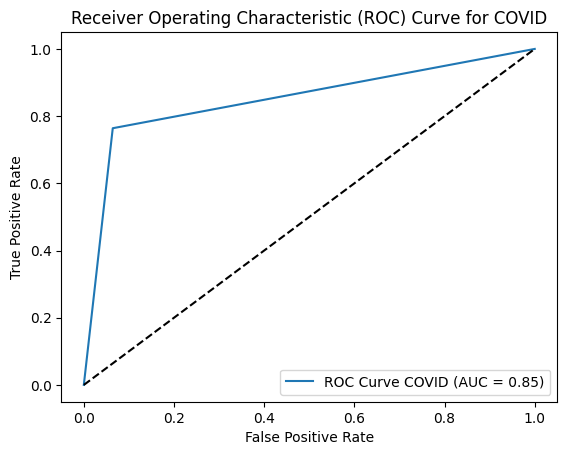

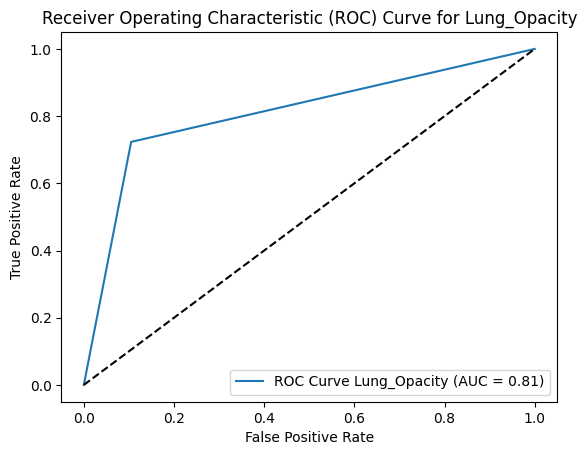

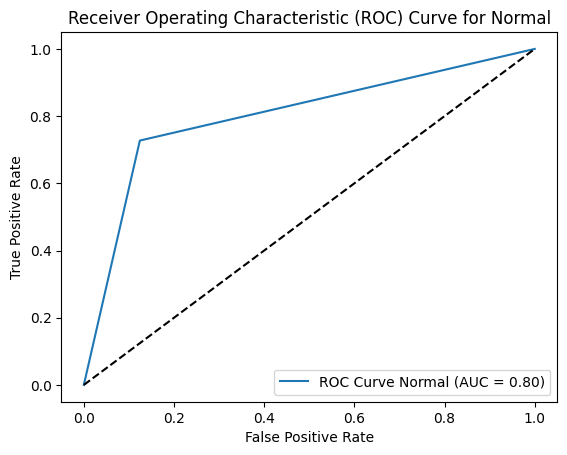

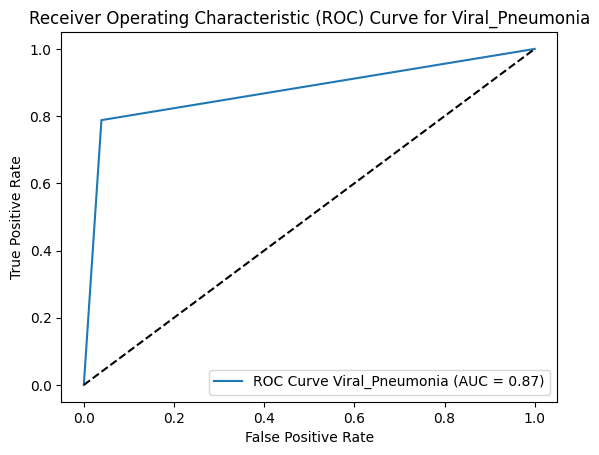

In [18]:
predictions = model_mlp.predict(X_test)
predictions = np.argmax(predictions, axis=1)
real_values = np.argmax(y_test, axis=1)

# get the metrics
print(confusion_matrix(real_values, predictions))
print("Accuracy: ", accuracy_score(real_values, predictions))
print("Precision: ", precision_score(real_values, predictions, average=None))
print("Recall: ", recall_score(real_values, predictions, average=None))
print("F1 score: ", f1_score(real_values, predictions, average=None))

# for auc and roc there is an analysis for each category
# get the accurate predictions matrix
test_label_mat = []
predictions_mat = []

covid_true = []
lung_op_true = []
normal_true = []
viral_pneu_true = []

covid_pred = []
lung_op_pred = []
normal_pred = []
viral_pneu_pred = []

for i in range(len(real_values)):
    
    # y_test
    covid_true.append(real_values[i] == 0)
    lung_op_true.append(real_values[i] == 1)
    normal_true.append(real_values[i] == 2)
    viral_pneu_true.append(real_values[i] == 3)

    # predictions
    covid_pred.append(predictions[i] == 0)
    lung_op_pred.append(predictions[i] == 1)
    normal_pred.append(predictions[i] == 2)
    viral_pneu_pred.append(predictions[i] == 3)

test_label_mat.append(covid_true)
test_label_mat.append(lung_op_true)
test_label_mat.append(normal_true)
test_label_mat.append(viral_pneu_true)

predictions_mat.append(covid_pred)
predictions_mat.append(lung_op_pred)
predictions_mat.append(normal_pred)
predictions_mat.append(viral_pneu_pred)

# print the results and make the needed graphics
auc = roc_auc_score(test_label_mat, predictions_mat, multi_class='ovo')
print("General AUC:", auc)

categories = {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral_Pneumonia': 3}

for category, value in categories.items():

    fpr, tpr, thresholds = roc_curve(test_label_mat[value], predictions_mat[value])

    auc = roc_auc_score(test_label_mat[value], predictions_mat[value])

    plt.plot(fpr, tpr, label=f'ROC Curve {category} (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing the random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {category}')
    plt.legend(loc='lower right')
    plt.show()